# Attention Mechanism
* seq2seq 모형의 sequence가 길어질 수록 과거 상태를 기억하지 못하는 단점이 존재해서 별도의 네트웍을 이용해 우리가 주목해야될 벡터가 무엇인지 강조해 주는데 목적이 있음
<p>
[링크](https://www.slideshare.net/healess/attention-mechanismseq2seq "Slideshare") Slideshare


## Seq2Seq에 Attention을 적용하여 간단한 Q/A 봇을 만들어보자
![이미지](https://image.slidesharecdn.com/attentionmechanism-180209134411/95/attention-mechanismseq2seq-5-638.jpg?cb=1518184094)
* Python 3.5, Tensorflow 1.1, Konlpy (Mecab),Word2Vec (Gensim), matplotlib (Graph)

In [13]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import re
from collections import Counter
from tqdm import tqdm
import tensorflow as tf
from tensorflow.python.layers.core import Dense
from konlpy.tag import Mecab

mecab = Mecab('/usr/local/lib/mecab/dic/mecab-ko-dic')
print(tf.__version__)

1.3.0


### seq2seq를 위한 Data 구성
* 질의 응답별로 LIST로 구성
* operator사용 value값 기준 정렬

In [14]:
enc_sentence_length = 10
dec_sentence_length = 10

train_data = [
    ['안녕', '만나서 반가워'],
    ['넌누구니', '나는 AI 봇이란다.'],
    ['피자 주문 할께', '페파로니 주문해줘'],
    ['음료는 멀로', '콜라로 해줘']
]


all_input_sentences = []
all_target_sentences = []

for row_data in train_data:
    all_input_sentences.append(row_data[0])
    all_target_sentences.append(row_data[1])

def tokenizer(sentence):
    tokens = mecab.morphs(sentence)
    return tokens

tokenizer('피자 주문 할께')

['피자', '주문', '할께']

# Vector 구성 (입력된 문장의 글자별 Vector)
 - 일반적으로 처리단위가 작아질수록 미등록어에서 자유롭고 작은 vector 차원을 유지할 수 있지만
 - 문장의 길이가 길어지고, 학습이 어려워지는 문제가 있기에 적절한 embedding을 찾아야하는데 
 - 이부분은 Biz Domain 별 차이가 있음 복잡도나 표현 가능성등을 적절한 균형에서 찾아야함 
 - 아래 소스는 이해하기 쉽도록 글자단위의 Onehot으로 구성

In [15]:
def build_vocab(sentences, is_target=False, max_vocab_size=None):
    word_counter = Counter()
    vocab = dict()
    reverse_vocab = dict()

    for sentence in sentences:
        tokens = tokenizer(sentence)
        word_counter.update(tokens)

    if max_vocab_size is None:
        max_vocab_size = len(word_counter)

    if is_target:
        vocab['_GO'] = 0
        vocab['_PAD'] = 1
        vocab_idx = 2
        for key, value in word_counter.most_common(max_vocab_size):
            vocab[key] = vocab_idx
            vocab_idx += 1
    else:
        vocab['_PAD'] = 0
        vocab_idx = 1
        for key, value in word_counter.most_common(max_vocab_size):
            vocab[key] = vocab_idx
            vocab_idx += 1

    for key, value in vocab.items():
        reverse_vocab[value] = key

    return vocab, reverse_vocab, max_vocab_size

enc_vocab, enc_reverse_vocab, enc_vocab_size = build_vocab(all_input_sentences)
dec_vocab, dec_reverse_vocab, dec_vocab_size = build_vocab(all_target_sentences, is_target=True)

print('input vocabulary size:', enc_vocab_size)
print('target vocabulary size:', dec_vocab_size)

def token2idx(word, vocab):
    return vocab[word]

for token in tokenizer('피자 주문 할께'):
    print(token, token2idx(token, enc_vocab))

def sent2idx(sent, vocab=enc_vocab, max_sentence_length=enc_sentence_length, is_target=False):
    tokens = tokenizer(sent)
    current_length = len(tokens)
    pad_length = max_sentence_length - current_length
    if is_target:
        return [0] + [token2idx(token, vocab) for token in tokens] + [1] * pad_length, current_length
    else:
        return [token2idx(token, vocab) for token in tokens] + [0] * pad_length, current_length

print('피자 주문 할께')
print(sent2idx('피자 주문 할께'))

print('페파로니 주문해줘')
print(sent2idx('페파로니 주문해줘', vocab=dec_vocab, max_sentence_length=dec_sentence_length, is_target=True))

def idx2token(idx, reverse_vocab):
    return reverse_vocab[idx]

def idx2sent(indices, reverse_vocab=dec_reverse_vocab):
    return " ".join([idx2token(idx, reverse_vocab) for idx in indices])

input vocabulary size: 11
target vocabulary size: 17
피자 5
주문 6
할께 7
피자 주문 할께
([5, 6, 7, 0, 0, 0, 0, 0, 0, 0], 3)
페파로니 주문해줘
([0, 14, 15, 16, 2, 3, 1, 1, 1, 1, 1], 5)


In [16]:
class Seq2SeqModel():
    def __init__(self, mode='training'):
        self.mode = mode

        self.hidden_size = 30
        self.enc_emb_size = 30
        self.dec_emb_size = 30
        self.attn_size = 30
        self.cell = tf.contrib.rnn.BasicLSTMCell

        self.optimizer = tf.train.AdamOptimizer
        self.n_epoch = 101
        self.learning_rate = 0.001

        self.start_token = 0
        self.end_token = 1

        self.ckpt_dir = './ckpt_dir/'

    def add_decoder(self):
        with tf.variable_scope('Decoder'):
            with tf.device('/cpu:0'):
                self.dec_Wemb = tf.get_variable('embedding',
                                                initializer=tf.random_uniform([dec_vocab_size + 2, self.dec_emb_size]),
                                                dtype=tf.float32)

            batch_size = tf.shape(self.enc_inputs)[0]

            dec_cell = self.cell(self.hidden_size)

            attn_mech = tf.contrib.seq2seq.LuongAttention(
                num_units=self.attn_size,
                memory=self.enc_outputs,
                memory_sequence_length=self.enc_sequence_length,
                name='LuongAttention')

            dec_cell = tf.contrib.seq2seq.AttentionWrapper(
                cell=dec_cell,
                attention_mechanism=attn_mech,
                attention_layer_size=self.attn_size,
                name='Attention_Wrapper')

            initial_state = dec_cell.zero_state(dtype=tf.float32, batch_size=batch_size)
            output_layer = Dense(dec_vocab_size + 2, name='output_projection')

            if self.mode == 'training':
                max_dec_len = tf.reduce_max(self.dec_sequence_length + 1, name='max_dec_len')

                dec_emb_inputs = tf.nn.embedding_lookup(
                    self.dec_Wemb, self.dec_inputs, name='emb_inputs')

                training_helper = tf.contrib.seq2seq.TrainingHelper(
                    inputs=dec_emb_inputs,
                    sequence_length=self.dec_sequence_length + 1,
                    time_major=False,
                    name='training_helper')

                training_decoder = tf.contrib.seq2seq.BasicDecoder(
                    cell=dec_cell,
                    helper=training_helper,
                    initial_state=initial_state,
                    output_layer=output_layer)

                train_dec_outputs, train_dec_last_state, _ = tf.contrib.seq2seq.dynamic_decode(
                    training_decoder,
                    output_time_major=False,
                    impute_finished=True,
                    maximum_iterations=max_dec_len)

                logits = tf.identity(train_dec_outputs.rnn_output, name='logits')
                targets = tf.slice(self.dec_inputs, [0, 0], [-1, max_dec_len], 'targets')
                masks = tf.sequence_mask(self.dec_sequence_length + 1, max_dec_len, dtype=tf.float32, name='masks')

                self.batch_loss = tf.contrib.seq2seq.sequence_loss(
                    logits=logits,
                    targets=targets,
                    weights=masks,
                    name='batch_loss')

                self.valid_predictions = tf.identity(train_dec_outputs.sample_id, name='valid_preds')

            elif self.mode == 'inference':

                start_tokens = tf.tile(tf.constant([self.start_token], dtype=tf.int32), [batch_size],
                                       name='start_tokens')

                inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
                    embedding=self.dec_Wemb,
                    start_tokens=start_tokens,
                    end_token=self.end_token)

                inference_decoder = tf.contrib.seq2seq.BasicDecoder(
                    cell=dec_cell,
                    helper=inference_helper,
                    initial_state=initial_state,
                    output_layer=output_layer)

                infer_dec_outputs, infer_dec_last_state, _ = tf.contrib.seq2seq.dynamic_decode(
                    inference_decoder,
                    output_time_major=False,
                    impute_finished=True,
                    maximum_iterations=dec_sentence_length)

                self.predictions = tf.identity(infer_dec_outputs.sample_id, name='predictions')

    def save(self, sess, var_list=None, save_path=None):
        print('Saving model at {save_path}')
        if hasattr(self, 'training_variables'):
            var_list = self.training_variables
        saver = tf.train.Saver(var_list)
        saver.save(sess, save_path, write_meta_graph=False)

    def build(self):
        self.enc_inputs = tf.placeholder(tf.int32, shape=[None, enc_sentence_length], name='input_sentences')
        self.enc_sequence_length = tf.placeholder(tf.int32, shape=[None, ], name='input_sequence_length')

        if self.mode == 'training':
            self.dec_inputs = tf.placeholder(tf.int32, shape=[None, dec_sentence_length + 1], name='target_sentences')
            self.dec_sequence_length = tf.placeholder(tf.int32, shape=[None, ], name='target_sequence_length')

        with tf.variable_scope('Encoder'):
            with tf.device('/cpu:0'):
                self.enc_Wemb = tf.get_variable('embedding',
                                                initializer=tf.random_uniform([enc_vocab_size + 1, self.enc_emb_size]),
                                                dtype=tf.float32)

            enc_emb_inputs = tf.nn.embedding_lookup(self.enc_Wemb, self.enc_inputs, name='emb_inputs')
            enc_cell = self.cell(self.hidden_size)

            self.enc_outputs, self.enc_last_state = tf.nn.dynamic_rnn(
                cell=enc_cell,
                inputs=enc_emb_inputs,
                sequence_length=self.enc_sequence_length,
                time_major=False,
                dtype=tf.float32)

        self.add_decoder()

    def train(self, sess, data, save_path=None):
        print(data)

        self.training_op = self.optimizer(self.learning_rate, name='training_op').minimize(self.batch_loss)

        sess.run(tf.global_variables_initializer())

        loss_history = []

        for epoch in tqdm(range(self.n_epoch)):

            all_preds = []
            epoch_loss = 0
            for row_data in data:
                input_batch_tokens = []
                target_batch_tokens = []
                enc_sentence_lengths = []
                dec_sentence_lengths = []

                tokens, sent_len = sent2idx(row_data[0])
                input_batch_tokens.append(tokens)
                enc_sentence_lengths.append(sent_len)

                tokens, sent_len = sent2idx(row_data[1],
                                            vocab=dec_vocab,
                                            max_sentence_length=dec_sentence_length,
                                            is_target=True)
                target_batch_tokens.append(tokens)
                dec_sentence_lengths.append(sent_len)

                batch_preds, batch_loss, _ = sess.run(
                    [self.valid_predictions, self.batch_loss, self.training_op],
                    feed_dict={
                        self.enc_inputs: input_batch_tokens,
                        self.enc_sequence_length: enc_sentence_lengths,
                        self.dec_inputs: target_batch_tokens,
                        self.dec_sequence_length: dec_sentence_lengths,
                    })
                epoch_loss += batch_loss
                all_preds.append(batch_preds)

            loss_history.append(epoch_loss)

            if epoch % 100 == 0:
                print('Epoch', epoch)
                for row_data, batch_preds in zip(data, all_preds):

                    for input_sent, target_sent, pred in zip(row_data[0], row_data[1], batch_preds):
                        print('\tInput: {input_sent}')
                        print('\tPrediction:', idx2sent(pred, reverse_vocab=dec_reverse_vocab))
                        print('\tTarget:, {target_sent}')
                print('\tepoch loss: {epoch_loss:.2f}\n')

        if save_path:
            self.save(sess, save_path=save_path)

        return loss_history

    def inference(self, sess, data, load_ckpt):
        self.restorer = tf.train.Saver().restore(sess, load_ckpt)

        batch_tokens = []
        batch_sent_lens = []

        tokens, sent_len = sent2idx(data)
        batch_tokens.append(tokens)
        batch_sent_lens.append(sent_len)

        batch_preds = sess.run(
            self.predictions,
            feed_dict={
                self.enc_inputs: batch_tokens,
                self.enc_sequence_length: batch_sent_lens,
            })

        print('Input:', data)
        print('Prediction:', idx2sent(batch_preds[0], reverse_vocab=dec_reverse_vocab))

### 학습결과 출력
* matplotlib 활용 학습 결과 출력

[['안녕', '만나서 반가워'], ['넌누구니', '나는 AI 봇이란다.'], ['피자 주문 할께', '페파로니 주문해줘'], ['음료는 멀로', '콜라로 해줘']]


  5%|▍         | 5/101 [00:00<00:04, 21.81it/s]

Epoch 0
	Input: {input_sent}
	Prediction: 줘 란다 란다 는
	Target:, {target_sent}
	Input: {input_sent}
	Prediction: 줘 줘 줘 란다 란다 란다 줘 줘
	Target:, {target_sent}
	Input: {input_sent}
	Prediction: 줘 줘 줘 줘 _GO 란다
	Target:, {target_sent}
	Input: {input_sent}
	Prediction: 봇 _GO _GO _GO _GO
	Target:, {target_sent}
	epoch loss: {epoch_loss:.2f}



100%|██████████| 101/101 [00:03<00:00, 33.05it/s]


Epoch 100
	Input: {input_sent}
	Prediction: _GO 만나 서 반가워
	Target:, {target_sent}
	Input: {input_sent}
	Prediction: _GO 나 는 AI 봇 이 란다 .
	Target:, {target_sent}
	Input: {input_sent}
	Prediction: _GO 페파 로니 주문 해 줘
	Target:, {target_sent}
	Input: {input_sent}
	Prediction: _GO 콜라 로 해 줘
	Target:, {target_sent}
	epoch loss: {epoch_loss:.2f}

Saving model at {save_path}


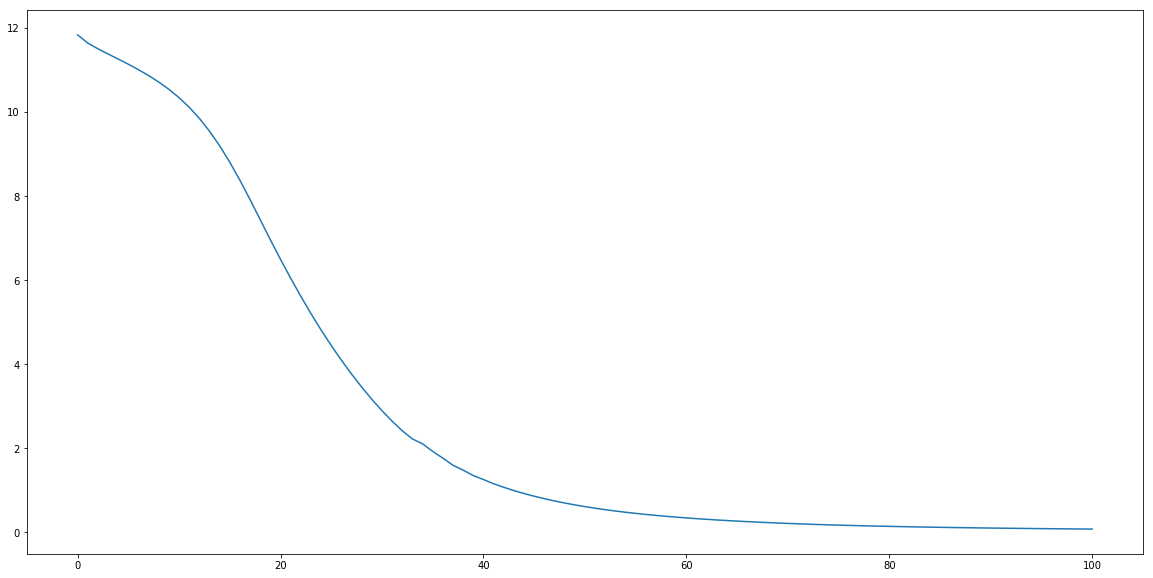

In [17]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = Seq2SeqModel(mode='training')
    model.build()
    loss_history = model.train(sess, train_data, save_path=model.ckpt_dir)

plt.figure(figsize=(20, 10))
plt.plot(range(model.n_epoch), loss_history, label = 'cost')
plt.show()

### 예측 수행

In [18]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = Seq2SeqModel(mode='inference')
    model.build()
    for row_data in train_data:
        model.inference(sess, row_data[0], load_ckpt=model.ckpt_dir)
        
    import shutil
    shutil.rmtree(model.ckpt_dir)
    print("Model Deleted")

INFO:tensorflow:Restoring parameters from ./ckpt_dir/
Input: 안녕
Prediction: _GO 만나 서 반가워 반가워 반가워 반가워 반가워 반가워 반가워
INFO:tensorflow:Restoring parameters from ./ckpt_dir/
Input: 넌누구니
Prediction: _GO 나 는 AI 봇 이 이 란다 . .
INFO:tensorflow:Restoring parameters from ./ckpt_dir/
Input: 피자 주문 할께
Prediction: _GO 페파 로니 주문 해 줘 줘 줘 줘 줘
INFO:tensorflow:Restoring parameters from ./ckpt_dir/
Input: 음료는 멀로
Prediction: _GO 콜라 로 해 해 줘 줘 줘 줘 줘
Model Deleted
